In [ ]:
import os
import time
import heapq as hq
import numpy as np
import pandas as pd
from tqdm import tqdm
import pdb
from multiprocessing import Pool, cpu_count


class CollaborativeFiltering:
    def __init__(self, min_common_user: int, save_topk=None):
        self.movie_similary = dict()
        self.save_topk = save_topk
        self.min_common_user = min_common_user
        self.movie_user = dict()    # 每部电影被哪些用户看过
        self.movie_rating = dict()    # 每部电影被哪些用户看过相应的评分
        self.user_dict = dict()     # 每个用户看过哪些电影
        self.data = None


    def cosin_similary(self, m1, m2):
        users1 = self.movie_user[m1]
        users2 = self.movie_user[m2]
        scores1 = self.movie_rating[m1]
        scores2 = self.movie_rating[m2]

        map1 = {u: r for u, r in zip(users1, scores1)}
        map2 = {u: r for u, r in zip(users2, scores2)}

        common_users = list(set(map1.keys()) & set(map2.keys()))
        if len(common_users) < self.min_common_user:
            return None

        common_users.sort()
        # 建模的是对于这两部电影，每个用户的评分会比平时高/低多少，计算两个差值向量的相似度
        v1 = np.array([map1[u] - self.user_mean[u] for u in common_users], dtype=np.float64)
        v2 = np.array([map2[u] - self.user_mean[u] for u in common_users], dtype=np.float64)

        norm1 = np.linalg.norm(v1)
        norm2 = np.linalg.norm(v2)
        if norm1 == 0 or norm2 == 0:
            return None

        sim = np.dot(v1, v2) / (norm1 * norm2)
        return sim


    def keep_topk_sim(self, heap_m, insert_m, sim):
        small_heap = self.movie_similary[heap_m]
        if self.save_topk is None:
            small_heap.append((sim, insert_m))
        else:
            if len(small_heap) < self.save_topk:
                hq.heappush(small_heap, (sim, insert_m))
            else:
                if sim > small_heap[0][0]:
                    hq.heapreplace(small_heap, (sim, insert_m))


    def compute_user_mean(self):
        user_sum = {}
        user_cnt = {}

        for movie, users in self.movie_user.items():
            scores = self.movie_rating[movie]
            for u, r in zip(users, scores):
                user_sum[u] = user_sum.get(u, 0.0) + r
                user_cnt[u] = user_cnt.get(u, 0) + 1

        self.user_mean = {u: user_sum[u] / user_cnt[u] for u in user_sum}


    def train(self, data: pd.DataFrame):
        movie = list(set(data["movieId"]))
        for m in movie:
            self.movie_similary.update({m: []})

        for row in data.itertuples(index=False):
            user_id = row.userId
            user_rating = row.rating
            movie_id = row.movieId
            if user_id not in self.user_dict:
                self.user_dict.update({user_id: [movie_id]})
            else:
                self.user_dict[user_id].append(movie_id)
            
            if movie_id not in self.movie_user:
                self.movie_user.update({movie_id: [user_id]})
                self.movie_rating.update({movie_id: [user_rating]})
            else:
                self.movie_user[movie_id].append(user_id)
                self.movie_rating[movie_id].append(user_rating)
        
        self.compute_user_mean()

        with Pool(cpu_count()) as executor:
            for i1, m1 in enumerate(movie):
                task = list(zip([m1] * (len(movie) - i1 - 1), movie[i1+1:]))
                sim_lis = executor.starmap(self.cosin_similary, task)
                for i2, sim in enumerate(sim_lis):
                    if sim is not None:
                        m2 = movie[i2 + i1 + 1]
                        self.keep_topk_sim(m1, m2, sim)
                        self.keep_topk_sim(m2, m1, sim)
            
                percent = i1 / len(movie) * 100
                print(f"\rProgress: {percent:6.2f}%", end="")



    def predict(self, user_id, movie_id):
        user_seen = self.user_dict[user_id]
        candidate = []
        for s, movie in self.movie_similary[movie_id]:      # 查找相似电影中用户看过的电影
            if movie in user_seen:
                for idx, u in enumerate(self.movie_user[movie]):    # 找到用户当时的评分
                    if u == user_id:
                        candidate.append((movie, s, self.movie_rating[movie][idx]))
                        break
        
        # 在相似电影且该用户看过的情况下，加权它们与用户平时评分的差值
        pred = sum(item[1] * (item[2] - self.user_mean[user_id]) for item in candidate) / sum(np.abs(item[1]) for item in candidate)
        return pred + self.user_mean[user_id]

df = pd.read_csv("C:\\vscode_project\\data_mining_homework\\data\\ml-latest-small\\ratings.csv")
df = df.sort_values("movieId")
cf = CollaborativeFiltering(2)
cf.train(df)

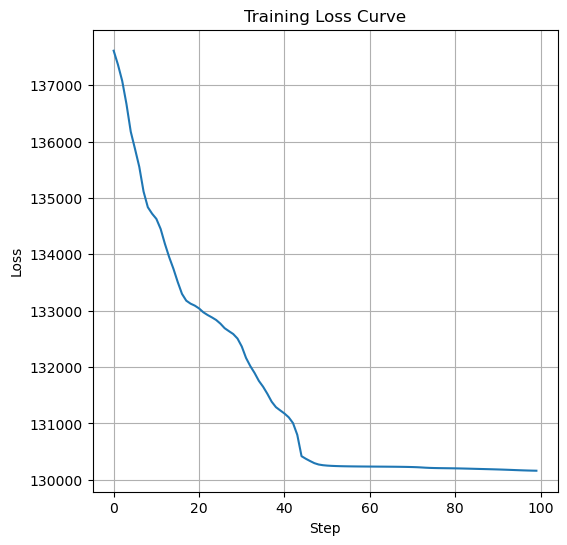

: 

In [ ]:
import json
import matplotlib.pyplot as plt

def plot_loss_from_jsonl(jsonl_path):
    losses = []

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            data = json.loads(line)
            if "loss" in data:
                losses.append(data["loss"])

    plt.figure(figsize=(6, 6))
    plt.plot(losses)
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.grid(True)
    plt.show()
plot_loss_from_jsonl("./result/GMM/GMM_log_19.jsonl")

In [ ]:
import random
import numpy as np

def test_cf_on_5_users(cf):
    # ===== 1. 构建 user -> [(movie, rating), ...] =====
    user_ratings = {}

    for movie, users in cf.movie_user.items():
        scores = cf.movie_rating[movie]
        for u, r in zip(users, scores):
            user_ratings.setdefault(u, []).append((movie, r))

    # 只保留评分数 >= 2 的用户（否则没法留一）
    valid_users = [u for u in user_ratings if len(user_ratings[u]) >= 2]

    # ===== 2. 随机选 5 个用户 =====
    test_users = random.sample(valid_users, 5)

    errors = []
    abs_errors = []

    for u in test_users:
        items = user_ratings[u]

        # 随机留一条评分
        test_movie, true_rating = random.choice(items)

        # ===== 3. 临时“遮蔽”该评分 =====
        # 从该 movie 的用户列表中移除 u
        idx = cf.movie_user[test_movie].index(u)

        backup_user = cf.movie_user[test_movie][idx]
        backup_score = cf.movie_rating[test_movie][idx]

        cf.movie_user[test_movie].pop(idx)
        cf.movie_rating[test_movie].pop(idx)

        try:
            # ===== 4. 预测 =====
            pred = cf.predict(u, test_movie)

            # 如果你的 predict 可能返回 None
            if pred is None:
                continue

            errors.append((pred - true_rating) ** 2)
            abs_errors.append(abs(pred - true_rating))

            print(f"User {u}, Movie {test_movie}, True={true_rating:.1f}, Pred={pred:.3f}")

        finally:
            # ===== 5. 恢复数据 =====
            cf.movie_user[test_movie].insert(idx, backup_user)
            cf.movie_rating[test_movie].insert(idx, backup_score)

    # ===== 6. 计算指标 =====
    rmse = np.sqrt(np.mean(errors))
    mae = np.mean(abs_errors)

    print("\n===== Evaluation Result =====")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")


test_cf_on_5_users(cf)